# Generating images of cars with Generative Adversarial Network
Just a very straight-forward GAN trained on the Stanford cars dataset: http://ai.stanford.edu/~jkrause/cars/car_dataset.html

Next steps are to create a conditional GAN (possibly using styleGAN2) that will generate images of cars using text prompts to include certain design features (e.g., sports car, red, make, etc).


In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time

# 1.0 Data prep

In [2]:
dataset, info = tfds.load('cars196', split='train', with_info=True) #stanford cars dataset

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/cars196/2.1.0.incomplete3E5C45/cars196-train.tfrecord*...:   0%|          …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cars196/2.1.0.incomplete3E5C45/cars196-test.tfrecord*...:   0%|          |…

Dataset cars196 downloaded and prepared to /root/tensorflow_datasets/cars196/2.1.0. Subsequent calls will reuse this data.


In [3]:
dataset

<PrefetchDataset element_spec={'bbox': TensorSpec(shape=(4,), dtype=tf.float32, name=None), 'id': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [4]:
# Define the input shape of the generator and discriminator
input_shape = (64, 64, 3)

# Define the size of the noise vector used as input to the generator
noise_dim = 100

# Preprocess the dataset
def preprocess_image(data):
    image = tf.cast(data['image'], tf.float32)
    image = tf.image.resize(image, (64, 64))
    image = (image - 127.5) / 127.5
    return image

dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.cache().shuffle(info.splits['train'].num_examples).batch(128).prefetch(tf.data.experimental.AUTOTUNE)
# dataset = dataset.take(10)

In [5]:
# Define the generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(8 * 8 * 256, input_shape=(noise_dim,)))
    model.add(tf.keras.layers.Reshape((8, 8, 256)))
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

# Define the discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    return model

# Instantiate the generator and discriminator models
generator = make_generator_model()
discriminator = make_discriminator_model()

# Define the loss function and optimizers for the generator and discriminator
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [6]:
# # Display a few samples of the training dataset
# plt.figure(figsize=(10, 10))
# for images in dataset.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow((images[i].numpy() * 127.5 + 127.5).astype('uint8'))
#         plt.axis('off')

#2.0 Model

In [7]:
noise = tf.random.normal([1, noise_dim])
print('Noise shape:', noise.shape)


Noise shape: (1, 100)


In [8]:
# Define the generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 8 * 8 * 256)

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(4, 4), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model


# Define the discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# Create an instance of the generator model and print its summary
generator = make_generator_model()
generator.summary()

# Create an instance of the discriminator model and print its summary
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_2 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_3 (Batc  (None, 8, 8, 128)       

In [9]:
# Create an instance of the discriminator model and print its summary
discriminator = make_discriminator_model()
discriminator.summary()

# Define the loss functions for the generator and the discriminator
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Define the optimizers for the generator and the discriminator
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Define a checkpoint directory to save the model weights during training
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       204928    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 flatten_2 (Flatten)         (None, 32768)            

# 3.0 Training loop

In [10]:
# Define the training loop
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Define a function to generate images using the generator model
def generate_and_save_images(model, epoch, test_input):
    # Generate images from the model
    predictions = model(test_input, training=False)
    # Rescale the pixel values to [0, 1] range
    predictions = (predictions + 1) / 2.0

    # Plot the generated images in a grid
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i])
        plt.axis('off')

    # Save the generated images
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Define a function to train the GAN
@tf.function
def train_step(images):
    # Generate random noise vectors
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # Train the discriminator
    with tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Train the generator
    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)

        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))


Time for epoch 1 is 381.63822889328003 sec


Time for epoch 2 is 340.2414140701294 sec


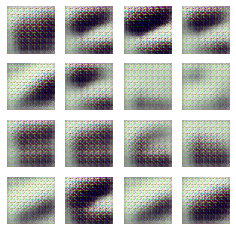

Time for epoch 3 is 354.7963778972626 sec


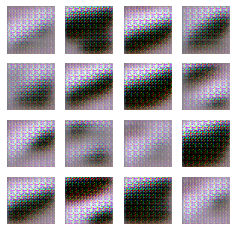

Time for epoch 4 is 338.5746786594391 sec


Time for epoch 5 is 340.165331363678 sec


Time for epoch 6 is 336.8785066604614 sec


Time for epoch 7 is 342.61700773239136 sec


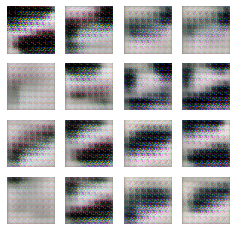

Time for epoch 8 is 337.8846871852875 sec


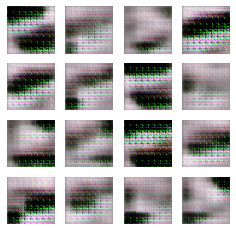

Time for epoch 9 is 337.46102643013 sec


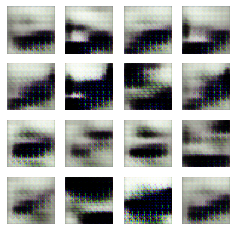

Time for epoch 10 is 338.8895523548126 sec


Time for epoch 11 is 337.32225275039673 sec


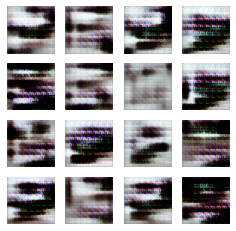

Time for epoch 12 is 338.4218668937683 sec


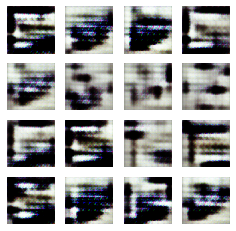

Time for epoch 13 is 337.56819772720337 sec


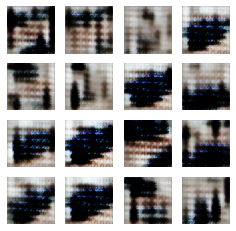

Time for epoch 14 is 337.9802234172821 sec


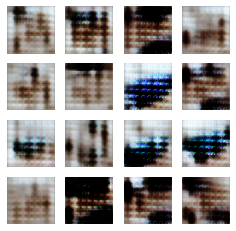

Time for epoch 15 is 336.2057535648346 sec


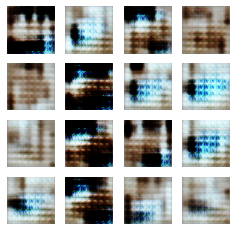

Time for epoch 16 is 325.7403635978699 sec


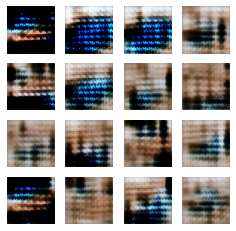

Time for epoch 17 is 329.3255181312561 sec


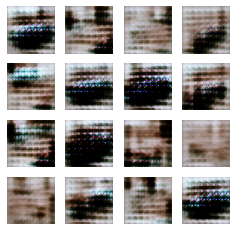

Time for epoch 18 is 326.372905254364 sec


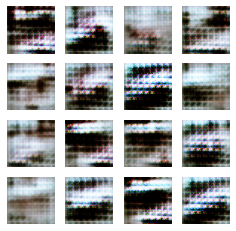

Time for epoch 19 is 325.8787090778351 sec


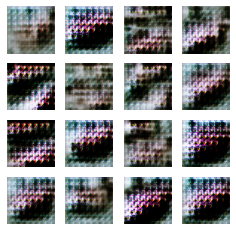

Time for epoch 20 is 325.5482883453369 sec


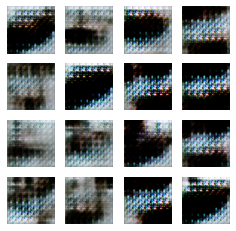

Time for epoch 21 is 327.006952047348 sec


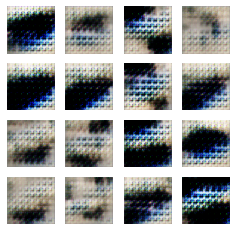

Time for epoch 22 is 326.3229765892029 sec


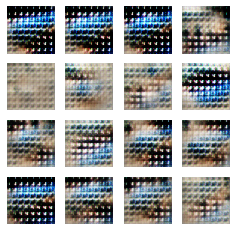

Time for epoch 23 is 325.53895592689514 sec


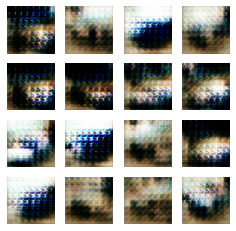

Time for epoch 24 is 326.6263978481293 sec


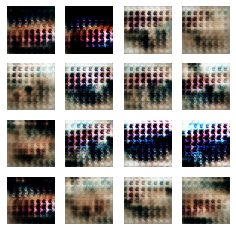

Time for epoch 25 is 327.5294871330261 sec


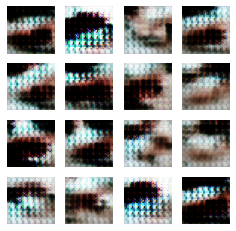

Time for epoch 26 is 327.6162347793579 sec


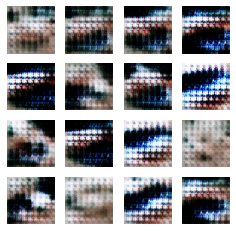

Time for epoch 27 is 328.52264618873596 sec


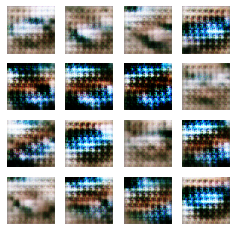

Time for epoch 28 is 328.0235524177551 sec


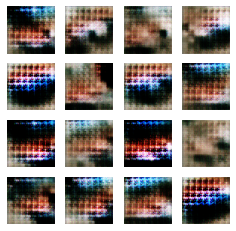

Time for epoch 29 is 327.1757764816284 sec


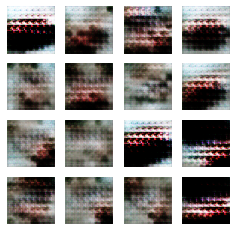

Time for epoch 30 is 327.10370206832886 sec


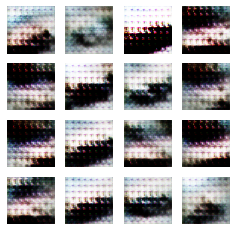

Time for epoch 31 is 326.32533383369446 sec


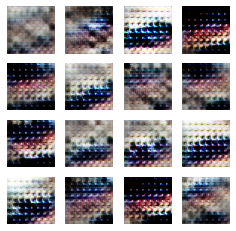

Time for epoch 32 is 326.1594684123993 sec


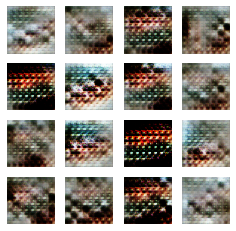

Time for epoch 33 is 326.1456632614136 sec


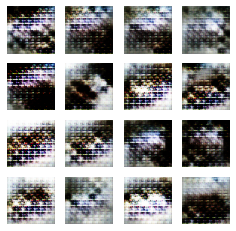

Time for epoch 34 is 325.56652760505676 sec


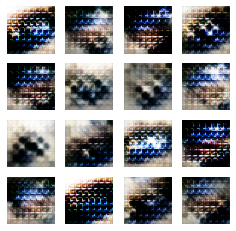

Time for epoch 35 is 324.7871582508087 sec


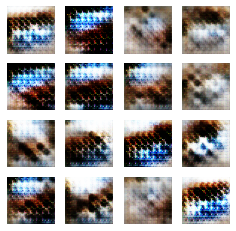

Time for epoch 36 is 324.5511689186096 sec


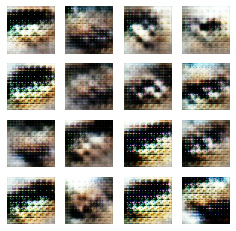

Time for epoch 37 is 324.45240211486816 sec


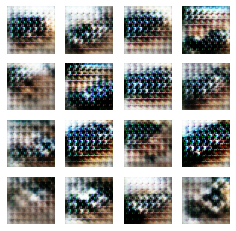

Time for epoch 38 is 324.47970056533813 sec


Time for epoch 39 is 324.6709225177765 sec


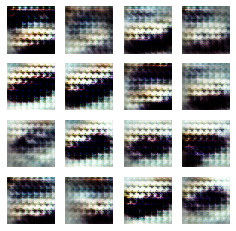

Time for epoch 40 is 324.5638859272003 sec


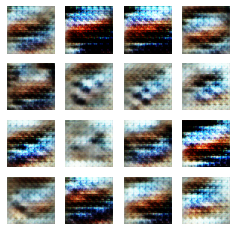

Time for epoch 41 is 324.2356972694397 sec


Time for epoch 42 is 324.11020398139954 sec


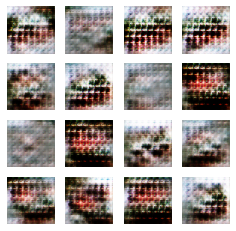

Time for epoch 43 is 328.01504397392273 sec


KeyboardInterrupt: ignored

In [11]:
# Train the GAN
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        # Generate a set of sample images every epoch
        generate_and_save_images(generator, epoch + 1, tf.random.normal([num_examples_to_generate, noise_dim]))

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate a set of sample images after the last epoch
    generate_and_save_images(generator, epochs, tf.random.normal([num_examples_to_generate, noise_dim]))

# Train the GAN on the training dataset
BATCH_SIZE = 128
train(dataset, EPOCHS)

In [ ]:
# Generate a set of sample images from the trained generator model
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, :])
plt.axis('off')
plt.show()